In [11]:
import csv
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint # Para RandomizedSearchCV


In [13]:
# Load data
X = pd.read_csv('train_values.csv')[:28955]
Y = pd.read_csv('train_labels.csv')[:28955]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert y_train and y_test to 1-dimensional arrays
y_train = y_train.values[:, 1]  # Select the first column
y_test = y_test.values[:, 1]    # Select the first column

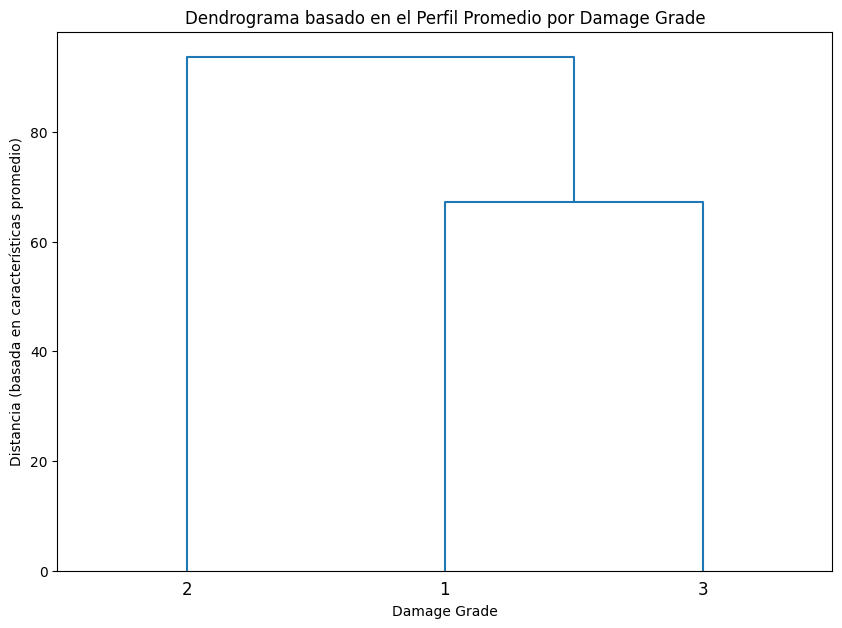

Formas de los datos listos para LazyClassifier:
X_train: (23164, 39)
X_test: (5791, 39)
y_train: (23164,)
y_test: (5791,)


In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
# Usaremos X_train y y_train para el análisis
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- Preprocesamiento de X_train ---
# Convertir columnas categóricas a numéricas en X_train
label_encoders = {}
categorical_cols = X_train_df.select_dtypes(include=['object']).columns
X_train_processed = X_train_df.copy() # Crear una copia para el preprocesamiento

# Eliminar la columna 'building_id' si existe, ya que no es una característica útil para el clustering
if 'building_id' in X_train_processed.columns:
    X_train_processed = X_train_processed.drop('building_id', axis=1)
    categorical_cols = categorical_cols.drop('building_id', errors='ignore') # Quitarla de las categóricas también

for column in categorical_cols:
    le = LabelEncoder()
    # Asegurarse de ajustar y transformar solo en la copia
    X_train_processed[column] = le.fit_transform(X_train_processed[column])
    label_encoders[column] = le

# --- Preparación para el Dendrograma basado en damage_grade ---

# Extraer la columna objetivo 'damage_grade' de y_train
target_column_name = Y.columns[1] # Asumiendo que 'damage_grade' es la segunda columna
y_train_labels = y_train_df[target_column_name].values

# Combinar las características preprocesadas (X_train_processed) con las etiquetas (y_train_labels)
# Asegúrate de que los índices coincidan si has eliminado filas o reordenado
# Si X_train_processed mantiene el índice original de X_train_df, esto debería funcionar:
train_data_with_labels = X_train_processed.copy()
train_data_with_labels['damage_grade'] = y_train_labels

# Calcular el perfil promedio de características para cada damage_grade
# Agrupar por 'damage_grade' y calcular la media de todas las otras columnas (características)
average_profiles = train_data_with_labels.groupby('damage_grade').mean()

# --- Crear el Dendrograma ---

# Realizar el linkage sobre los perfiles promedio
# Usamos 'ward' como método, que tiende a encontrar clusters de varianza similar
Z_grades = linkage(average_profiles, method='ward')

# Crear el dendrograma
plt.figure(figsize=(10, 7))
plt.title("Dendrograma basado en el Perfil Promedio por Damage Grade")

# Usar las etiquetas de damage_grade (los índices de average_profiles) para el dendrograma
dendrogram(
    Z_grades,
    labels=average_profiles.index.astype(str).tolist(), # Convertir índices (1, 2, 3) a strings
    leaf_rotation=0,  # Rotar etiquetas si es necesario
    leaf_font_size=12 # Ajustar tamaño de fuente
)
plt.xlabel("Damage Grade")
plt.ylabel("Distancia (basada en características promedio)")
plt.show()


# Imprimir las formas de los datos listos para LazyClassifier
print("Formas de los datos listos para LazyClassifier:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


In [6]:
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)

#Vamos a usar una porción de los datasets para evitar problemas de memoria
models, predictions = clf.fit(X_train[:len(X_train)//2], X_test[:len(X_test)//2], y_train[:len(y_train)//2], y_test[:len(y_test)//2])
models

  0%|          | 0/31 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6500863557858376, 'Balanced Accuracy': np.float64(0.5369938574605627), 'ROC AUC': None, 'F1 Score': np.float64(0.6299144792498172), 'Time taken': 0.7087283134460449}
{'Model': 'BaggingClassifier', 'Accuracy': 0.6535405872193437, 'Balanced Accuracy': np.float64(0.5578458815058326), 'ROC AUC': None, 'F1 Score': np.float64(0.6456161589223531), 'Time taken': 0.699155330657959}
{'Model': 'BernoulliNB', 'Accuracy': 0.5005181347150259, 'Balanced Accuracy': np.float64(0.541694611518733), 'ROC AUC': None, 'F1 Score': np.float64(0.49967735140294317), 'Time taken': 0.0477902889251709}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6020725388601036, 'Balanced Accuracy': np.float64(0.4485111221263956), 'ROC AUC': None, 'F1 Score': np.float64(0.5513655263020721), 'Time taken': 2.7806649208068848}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.6006908462867012, 'Balanced Accuracy': np.float64(0.5383926336862365), 'ROC AUC': None, 'F1 Score': np.floa

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.69,0.58,None,0.68,0.26
BaggingClassifier,0.65,0.56,None,0.65,0.70
NearestCentroid,0.46,0.55,None,0.44,0.05
RandomForestClassifier,0.67,0.55,None,0.66,1.43
ExtraTreesClassifier,0.65,0.55,None,0.64,1.39
BernoulliNB,0.50,0.54,None,0.50,0.05
DecisionTreeClassifier,0.60,0.54,None,0.60,0.13
AdaBoostClassifier,0.65,0.54,None,0.63,0.71
GaussianNB,0.37,0.50,None,0.22,0.05


In [14]:
# Eliminar 'building_id' de las características y de Y
X = X.drop('building_id', axis=1)
building_ids_y = Y['building_id'] # Guardar por si acaso, aunque no se usa para entrenar
Y = Y['damage_grade'] # Usar directamente la serie de etiquetas

# Dividir en entrenamiento y prueba ANTES del preprocesamiento detallado
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) # Usar stratify para clasificación

# --- Preprocesamiento (Label Encoding) ---
categorical_cols = X_train.select_dtypes(include=['object']).columns
label_encoders = {}

# Crear copias para evitar SettingWithCopyWarning
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

print("Aplicando Label Encoding...")
for column in categorical_cols:
    print(f" - Columna: {column}")
    le = LabelEncoder()
    # Ajustar SOLO con datos de entrenamiento
    X_train_processed[column] = le.fit_transform(X_train_processed[column])
    # Transformar entrenamiento y prueba con el mismo encoder ajustado
    # Manejar valores desconocidos en el test set asignando un valor especial (ej: -1 o len(classes))
    X_test_processed[column] = X_test_processed[column].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    X_test_processed[column] = le.transform(X_test_processed[column])

    label_encoders[column] = le

print("\nPreprocesamiento completado.")
print("Formas de los datos procesados:")
print("X_train_processed:", X_train_processed.shape)
print("X_test_processed:", X_test_processed.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# Verificar si hay NaNs (puede ocurrir si el LabelEncoder falla en algún caso)
print("\nNaNs en X_train_processed:", X_train_processed.isnull().sum().sum())
print("NaNs en X_test_processed:", X_test_processed.isnull().sum().sum())
# Si hay NaNs, necesitarás imputarlos antes de entrenar. Ej:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='median') # o 'most_frequent'
# X_train_processed = imputer.fit_transform(X_train_processed)
# X_test_processed = imputer.transform(X_test_processed)


Aplicando Label Encoding...
 - Columna: land_surface_condition
 - Columna: foundation_type
 - Columna: roof_type
 - Columna: ground_floor_type
 - Columna: other_floor_type
 - Columna: position
 - Columna: plan_configuration
 - Columna: legal_ownership_status

Preprocesamiento completado.
Formas de los datos procesados:
X_train_processed: (23164, 38)
X_test_processed: (5791, 38)
y_train: (23164,)
y_test: (5791,)

NaNs en X_train_processed: 0
NaNs en X_test_processed: 0


In [15]:
# --- Definir Modelo y Espacios de Búsqueda ---

# Modelo base
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1) # n_jobs=-1 usa todos los cores

# 1. Espacio de búsqueda para GridSearchCV (combinaciones específicas)
param_grid = {
    'n_estimators': [100, 200],          # Número de árboles
    'max_depth': [None, 10, 20],         # Profundidad máxima
    'min_samples_split': [2, 5],         # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 3],          # Mínimo de muestras en un nodo hoja
    # 'max_features': ['sqrt', 'log2']   # Número de features a considerar (opcional)
    # 'class_weight': [None, 'balanced'] # Ponderación de clases (opcional, útil si hay desbalance)
}

# 2. Espacio de búsqueda para RandomizedSearchCV (distribuciones o rangos)
param_dist = {
    'n_estimators': randint(50, 300),     # Enteros aleatorios entre 50 y 299
    'max_depth': [None] + list(randint(5, 30).rvs(5)), # None o 5 profundidades aleatorias
    'min_samples_split': randint(2, 11),  # Enteros aleatorios entre 2 y 10
    'min_samples_leaf': randint(1, 6),    # Enteros aleatorios entre 1 y 5
    # 'max_features': ['sqrt', 'log2', None],
    # 'class_weight': [None, 'balanced']
}

# Número de iteraciones para RandomizedSearch (más iteraciones = más búsqueda, pero más tiempo)
n_iter_search = 20 # Puedes ajustar esto


In [16]:
# --- Ejecutar GridSearchCV ---
print("\n--- Iniciando GridSearchCV ---")
# Usaremos 'accuracy' como métrica, podrías usar 'f1_weighted' si las clases están desbalanceadas
# cv=3 para validación cruzada con 3 folds (puedes aumentarlo si tienes tiempo/recursos)
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1) # verbose alto para ver progreso

# Entrenar con los datos procesados
grid_search.fit(X_train_processed, y_train)

print("\n--- Resultados GridSearchCV ---")
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("\nMejor puntuación (accuracy) en validación cruzada:")
print(grid_search.best_score_)

# Evaluar el mejor modelo encontrado por GridSearch en el conjunto de prueba
best_grid_model = grid_search.best_estimator_
y_pred_grid = best_grid_model.predict(X_test_processed)
print("\nReporte de clasificación en Test (GridSearchCV):")
print(classification_report(y_test, y_pred_grid))
print("Accuracy en Test (GridSearchCV):", accuracy_score(y_test, y_pred_grid))



--- Iniciando GridSearchCV ---
Fitting 3 folds for each of 24 candidates, totalling 72 fits

--- Resultados GridSearchCV ---
Mejores parámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Mejor puntuación (accuracy) en validación cruzada:
0.6820066371290306

Reporte de clasificación en Test (GridSearchCV):
              precision    recall  f1-score   support

           1       0.59      0.34      0.43       559
           2       0.69      0.84      0.75      3285
           3       0.71      0.54      0.61      1947

    accuracy                           0.69      5791
   macro avg       0.66      0.57      0.60      5791
weighted avg       0.69      0.69      0.68      5791

Accuracy en Test (GridSearchCV): 0.6883094456915904


In [17]:
# --- Ejecutar RandomizedSearchCV ---
print("\n--- Iniciando RandomizedSearchCV ---")
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='accuracy',
                                   verbose=2, random_state=42, n_jobs=-1)

# Entrenar con los datos procesados
random_search.fit(X_train_processed, y_train)

print("\n--- Resultados RandomizedSearchCV ---")
print("Mejores parámetros encontrados:")
print(random_search.best_params_)
print("\nMejor puntuación (accuracy) en validación cruzada:")
print(random_search.best_score_)

# Evaluar el mejor modelo encontrado por RandomSearch en el conjunto de prueba
best_random_model = random_search.best_estimator_
y_pred_random = best_random_model.predict(X_test_processed)
print("\nReporte de clasificación en Test (RandomizedSearchCV):")
print(classification_report(y_test, y_pred_random))
print("Accuracy en Test (RandomizedSearchCV):", accuracy_score(y_test, y_pred_random))



--- Iniciando RandomizedSearchCV ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Resultados RandomizedSearchCV ---
Mejores parámetros encontrados:
{'max_depth': np.int64(28), 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 251}

Mejor puntuación (accuracy) en validación cruzada:
0.682913037400798

Reporte de clasificación en Test (RandomizedSearchCV):
              precision    recall  f1-score   support

           1       0.60      0.34      0.43       559
           2       0.68      0.85      0.76      3285
           3       0.73      0.51      0.60      1947

    accuracy                           0.69      5791
   macro avg       0.67      0.57      0.60      5791
weighted avg       0.69      0.69      0.67      5791

Accuracy en Test (RandomizedSearchCV): 0.688654809186669
